In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# Initialization

In [2]:
province_map = gpd.read_file('province_shapefile/Provinces.shp') #shapefile for province map of Philippines

In [3]:
prov_names = province_map['PROVINCE'].str.upper().values #Philippine provinces

## Creating Dataframe of Senatorial Election Results

The election results are contained in an .xls file, and each sheet is labeled per region. Pandas reads the data per sheet.

In [4]:
#create array containing the region names
sheets = ['Region 2','Region 3','Region 4-A','Region 4-B']
reg_num = np.arange(8)

for n in reg_num:
    sheets += ['Region '+str(n+5)]

sheets += ['ARMM','CARAGA','CAR','NCR']

In [5]:
data = pd.read_excel('per_precincts_senators.xls')

for s in sheets:
    #read the .xls file per sheet
    data_ = pd.read_excel('per_precincts_senators.xls',s) 
    data = pd.DataFrame.append(data,data_,ignore_index=True)

#replace all incomplete data with zeros
#we disregard these clustered precincts in the succeeding analyses
data = data.fillna(0)
senators = data.replace('-',0) 

We now create the matrix $\mathbf{Y}$ in the linear unmixing equation. 

In [6]:
senators = senators[senators['Total Registered Voters'] != 0] #disregard all incomplete data

In [7]:
can_votes = senators.iloc[:,6:].values #candidate votes per precinct
ballot_count = senators['Total Registered Voters'].values #total ballot count per precinct
candidate_frac = can_votes/ballot_count[:,None] #vote fractions per candidate

In [8]:
provinces = senators['Province'] #province per precinct

In [9]:
# np.save('precinct_province.npy',provinces)

## Creating dataframe of final results

We now create a dataframe containing the overall results or total votes per candidate. 

In [12]:
column_headers = ['candidate','total_votes']
candidates = data.columns.values[6:]
candidate_results = pd.DataFrame(columns=column_headers)

candidate_results['candidate'] = candidates
total_votes = []

for can in candidates:
    total_votes.append(senators[can].values.sum()) #total votes per candidate
    
candidate_results['total_votes'] = total_votes

final_winners_by_votes = candidate_results.sort_values('total_votes',ascending=False)

In [13]:
final_winners_by_votes[:12]

,candidate,total_votes
27,"POE, GRACE",16342460.0
18,"LEGARDA, LOREN (NPC)",14944788.0
12,"ESCUDERO, CHIZ",14139178.0
6,"CAYETANO, ALAN PETER (NP)",14131875.0
4,"BINAY, NANCY (UNA)",13312349.0
1,"ANGARA, EDGARDO (LDP)",12855085.0
2,"AQUINO, BENIGNO BAM (LP)",12378046.0
26,"PIMENTEL, KOKO (PDP)",11847477.0
29,"TRILLANES, ANTONIO IV (NP)",11390764.0
31,"VILLAR, CYNTHIA HANEPBUHAY (NP)",11071616.0


In [14]:
final_candidates = final_winners_by_votes['candidate'].values #candidates arranged from most to least total votes

In [15]:
# np.save('2013_candidates.npy',final_candidates)

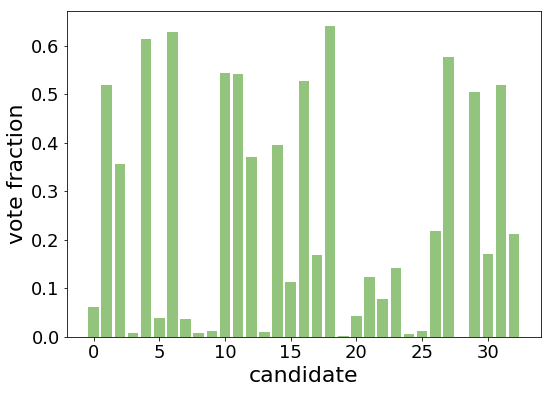

In [28]:
plt.figure(figsize=(8.5,6))
plt.bar(np.arange(33),candidate_frac[0],color='#93c47dff')
plt.xlabel('candidate',fontsize=22)
plt.ylabel('vote fraction',fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.savefig('vote_intensity.png',dpi=300,bbox_inches='tight')
plt.show()

## Saving the matrix of vote fractions into a .csv file

In [15]:
#arranged vote fractions based on candidate with highest to lowest total number of votes
sorted_results = pd.DataFrame(candidate_frac,columns=candidate_results.total_votes.tolist())
cand_list = pd.DataFrame([candidates],columns=candidate_results.total_votes.tolist())
sorted_results = sorted_results.append(cand_list,ignore_index=True)

sorted_votes = np.flip(np.array(sorted_results[sorted(sorted_results)].columns.tolist()))
sorted_results = sorted_results[sorted_votes]

sorted_results = sorted_results.fillna(0)

In [16]:
# np.savetxt('2013_senators.csv',sorted_results.values[:-1],delimiter=',')

The .csv file is exported to the MATLAB code for MVSA to perform linear unmixing. MVSA outputs the .csv file of the weights ($\mathbf{A}$) and archetype vote intensities ($\mathbf{M}$).

# Plotting Archetypes with Weight Distribution

In [17]:
def archetype_plots(arc_senators,abundance):    
    weight_sum = [] 
    normalization = []
    pos = np.arange(sen_num) #create array total number of senators

    for n in range(arc_senators.shape[1]): #plotting per archetype
        sorted_arc = arc_senators[n]
        
        peak = max(sorted_arc) #get maximum vote intensity per archetype
        mean = np.mean(sorted_arc) #get mean of vote intensities per archetype
        sigma = np.std(sorted_arc) #get standard deviation of vote intensities per archetype
        
        plt.figure(figsize=(8.5,6))
        
        ax1 = plt.axes()  # standard axes
        ax2 = plt.axes([0.60, 0.625, 0.26, 0.24])
        
        ax1.bar(pos,sorted_arc/peak) #normalize vote intensities
        ax1.axhline((mean+sigma)/peak,color='black',linestyle='--',label='$\mu + \sigma$') #plot the mean+one standard dev line
        ax1.set_xticks(np.arange(0,sen_num+1,5))
        ax1.set_xlabel('candidate',fontsize=14)
        ax1.set_ylabel('intensity',fontsize=14)
        ax1.grid(b=True,axis='both')
        ax1.margins(0.03)
        ax1.legend(loc='lower right')
        
        histogram = np.histogram(peak*abundance[n],bins=40) #plot the weight distribution as an inset
        ax2.bar(histogram[1][:-1],histogram[0]/len(abundance[n]),width=np.diff(histogram[1])[0],color='mediumseagreen')
        ax2.set_ylabel('frequency',fontsize=10)
        ax2.set_xlabel('weights',fontsize=10)
        ax2.set_xticks(np.arange(0,1.2,0.4))
        ax2.set_xlim(0,0.8)
        
#         plt.savefig('archetype_'+str(n+1)+'.png',dpi=600,bbox_inches='tight')
        plt.show()
    
        weight_sum.append(np.sum(abundance[n])) #sum of weights per archetype
        normalization.append(peak) #store the maximum vote intensity per archetype
        
    return weight_sum,normalization

# Looking at endmember signatures for MVSA

In [18]:
#read files containing archetype signatures and weights obtained from MVSA MATLAB code

MVSA_senators = pd.read_csv('MVSA_senators_2013.csv',header=None)
MVSA_abundance = pd.read_csv('MVSA_abundances_2013.csv',header=None).values

## MVSA Archetypes

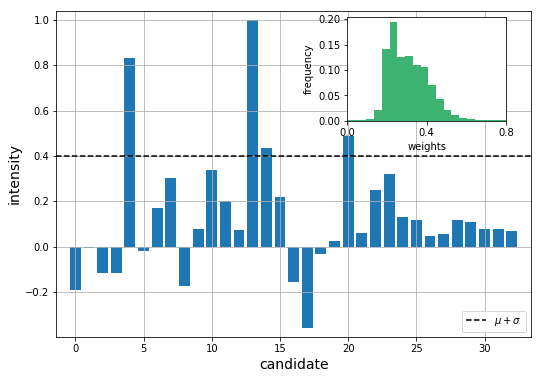

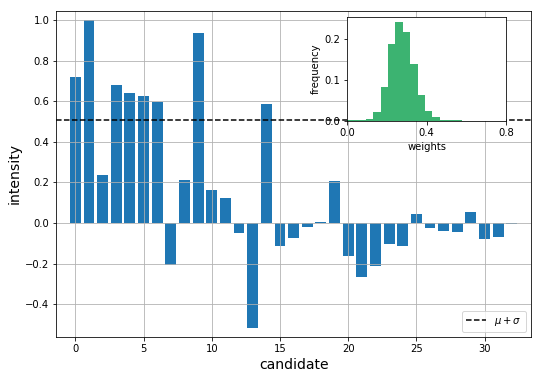

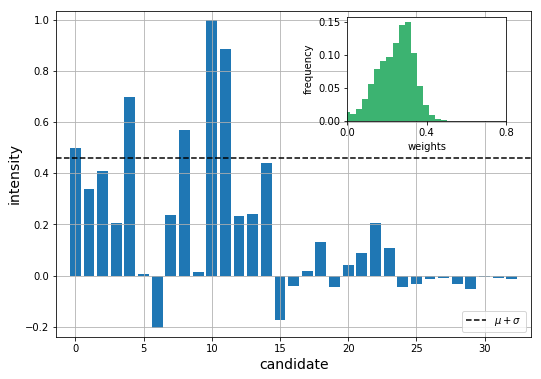

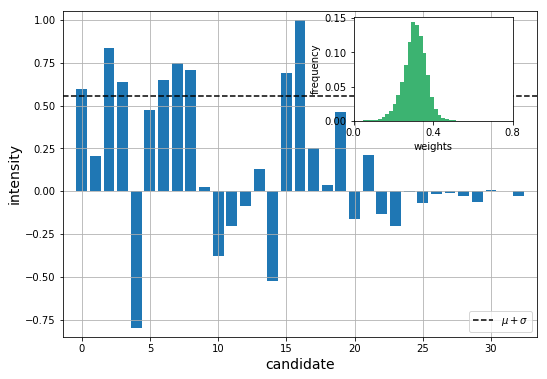

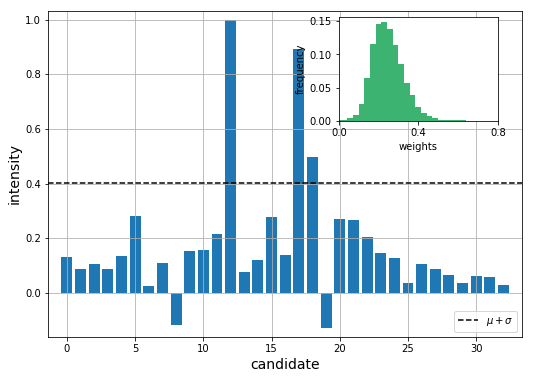

In [19]:
sen_num = len(final_candidates)

weight_sum_MVSA, MVSA_normalization = archetype_plots(MVSA_senators,MVSA_abundance)

## Archetype with highest sum of weights.

In [20]:
print('Archetype',np.argmax(weight_sum_MVSA)+1,'has the most weights sum.')

Archetype 4 has the most weights sum.


## List of candidates arranged alphabetically

In [21]:
candidates

array(['ALCANTARA, SAMSON (SJS)', 'ANGARA, EDGARDO (LDP)',
       'AQUINO, BENIGNO BAM (LP)', 'BELGICA, GRECO (DPP)',
       'BINAY, NANCY (UNA)', 'CASINO, TEDDY (MKB)',
       'CAYETANO, ALAN PETER (NP)', 'COJUANGCO, TINGTING (UNA)',
       'DAVID, LITO (KPTRAN)', 'DELOS REYES, JC (KPTRAN)',
       'EJERCITO ESTRADA, JV (UNA)', 'ENRILE, JUAN PONCE JR.(NPC)',
       'ESCUDERO, CHIZ', 'FALCONE, BAL (DPP)', 'GORDON, DICK (UNA)',
       'HAGEDORN, ED', 'HONASAN, GRINGO (UNA)',
       'HONTIVEROS, RISA (AKBAYAN)', 'LEGARDA, LOREN (NPC)',
       'LLASOS, MARWIL (KPTRAN)', 'MACEDA, MANONG ERNIE (UNA)',
       'MADRIGAL, JAMBY (LP)', 'MAGSAYSAY, MITOS (UNA)',
       'MAGSAYSAY, RAMON JR. (LP)', 'MONTANO, MON', 'PENSON, RICARDO',
       'PIMENTEL, KOKO (PDP)', 'POE, GRACE', 'SENERES, CHRISTIAN (DPP)',
       'TRILLANES, ANTONIO IV (NP)', 'VILLANUEVA, BRO.EDDIE (BP)',
       'VILLAR, CYNTHIA HANEPBUHAY (NP)', 'ZUBIRI, MIGZ (UNA)'],
      dtype=object)

## List of candidates from highest to lowest

In [22]:
final_candidates

array(['POE, GRACE', 'LEGARDA, LOREN (NPC)', 'ESCUDERO, CHIZ',
       'CAYETANO, ALAN PETER (NP)', 'BINAY, NANCY (UNA)',
       'ANGARA, EDGARDO (LDP)', 'AQUINO, BENIGNO BAM (LP)',
       'PIMENTEL, KOKO (PDP)', 'TRILLANES, ANTONIO IV (NP)',
       'VILLAR, CYNTHIA HANEPBUHAY (NP)', 'EJERCITO ESTRADA, JV (UNA)',
       'HONASAN, GRINGO (UNA)', 'GORDON, DICK (UNA)',
       'ZUBIRI, MIGZ (UNA)', 'ENRILE, JUAN PONCE JR.(NPC)',
       'MAGSAYSAY, RAMON JR. (LP)', 'HONTIVEROS, RISA (AKBAYAN)',
       'HAGEDORN, ED', 'VILLANUEVA, BRO.EDDIE (BP)',
       'MADRIGAL, JAMBY (LP)', 'MAGSAYSAY, MITOS (UNA)',
       'CASINO, TEDDY (MKB)', 'MACEDA, MANONG ERNIE (UNA)',
       'COJUANGCO, TINGTING (UNA)', 'DELOS REYES, JC (KPTRAN)',
       'ALCANTARA, SAMSON (SJS)', 'BELGICA, GRECO (DPP)',
       'PENSON, RICARDO', 'DAVID, LITO (KPTRAN)', 'MONTANO, MON',
       'LLASOS, MARWIL (KPTRAN)', 'SENERES, CHRISTIAN (DPP)',
       'FALCONE, BAL (DPP)'], dtype=object)

## Normalize weights

Since we divided the archetype vote intensities by their maximum values (essentially normalizing them), we have to multiply the same values to the weights to maintain the linear unmixing model.

In [23]:
norm_abundance = np.array(MVSA_normalization)*(MVSA_abundance.T)

## Arrange archetypes according mean of weights

In [24]:
arranged_index = np.flip(np.argsort(np.mean(norm_abundance.T,axis=1))) #calculate the weights mean of each archeytpe

In [25]:
MVSA_2013 = np.copy(MVSA_senators.T)
counter = 0

#arrange archetype sigantures based on obtained indices
for i in arranged_index:
    MVSA_2013[counter] = MVSA_senators.values.T[i]
    counter += 1

In [26]:
#save the arranged archetype signatures into a new .csv file
# np.savetxt('MVSA_2013.csv',MVSA_2013,delimiter=',')

In [27]:
#do the same for the weights
arranged_abundance = np.copy(norm_abundance.T)
counter = 0

for i in arranged_index:
    arranged_abundance[counter] = norm_abundance.T[i]
    counter += 1

# Determining dominant archetype for each province

In [28]:
def prov_weight(weights,tot_votes):
    #multiply the weights by the total ballot count to account for precincts with higher voting population
    weights = tot_votes*weights  
    
    arc_mean = np.mean(weights,axis=1)
    arc_median = np.median(weights,axis=1)
    
    #return the index of the archetype with the highest mean and median
    return np.argmax(arc_mean)+1,np.argmax(arc_median)+1

# Dominant archetype per province

In [29]:
provinces = np.array(provinces)

#province labels in Philippine map shapefile don't match the labels in the election data
provinces[(provinces == 'NATIONAL CAPITAL REGION - FOURTH DISTRICT') | (provinces == 'NATIONAL CAPITAL REGION - SECOND DISTRICT') | 
          (provinces == 'NATIONAL CAPITAL REGION - THIRD DISTRICT') | (provinces == 'NATIONAL CAPITAL REGION - MANILA')] = 'METROPOLITAN MANILA'
provinces[provinces == 'DAVAO (DAVAO DEL NORTE)'] = 'DAVAO DEL NORTE'
provinces[provinces == 'SAMAR (WESTERN SAMAR)'] = 'SAMAR'
provinces[provinces == 'COTABATO (NORTH COT.)'] = 'NORTH COTABATO'
prov_names[prov_names == 'SHARIFF KABUNSUAN'] = 'MAGUINDANAO'

In [30]:
province_index = [] #index of precincts per province

#group the clustered precincts based on province
for p in prov_names:
    province_index.append(np.where(provinces == p)[0])

In [31]:
dom_mean_arc = []
dom_median_arc = []

#calculate the dominant archetype per province
for m in range(len(prov_names)):
    prov_weights = arranged_abundance.T[province_index[m]] #weights corresponding to each province
    total_v = ballot_count[province_index[m]] #ballot counts per precinct in each province

    dom_mean,dom_median = prov_weight(np.array(prov_weights).T,total_v) #determine the dominant archetype using function
    
    dom_mean_arc.append('archetype '+str(dom_mean))
    dom_median_arc.append('archetype '+str(dom_median))

In [32]:
#store the dominant archetype corresponding to each province in the map
province_map['dom_mean_arc'] = dom_mean_arc 
province_map['dom_median_arc'] = dom_median_arc

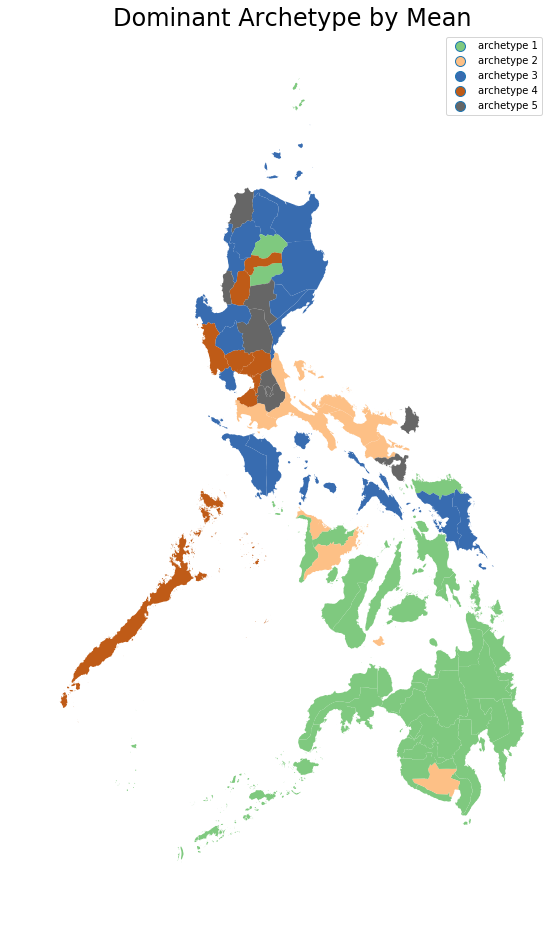

In [33]:
color = plt.get_cmap('Accent',5)
province_map.plot(column='dom_mean_arc',cmap=color,figsize=(18,16),legend=True)
plt.title('Dominant Archetype by Mean',fontsize=24)
plt.axis('off')
# plt.savefig('2013_map_mean.png',bbox_inches='tight',dpi=600)
plt.show()

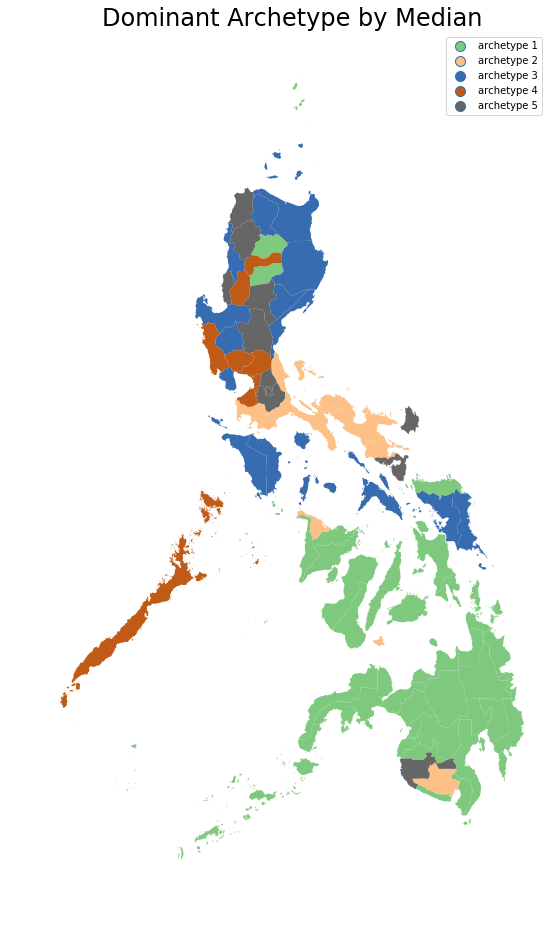

In [34]:
color = plt.get_cmap('Accent',5)
province_map.plot(column='dom_median_arc',cmap=color,figsize=(18,16),legend=True)
plt.title('Dominant Archetype by Median',fontsize=24)
plt.axis('off')
# plt.savefig('2013_map_poster.png',bbox_inches='tight',dpi=300)
plt.show()